In [244]:
import os
import math

import cv2
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [245]:
bs = 20

In [264]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conf_module = nn.Sequential(
                nn.Conv2d(1, 8, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(8),
                nn.MaxPool2d(2),

                nn.Conv2d(8, 16, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(16),
                nn.Dropout2d(.5),
            
                nn.Conv2d(16, 32, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2),
            
                nn.Conv2d(32, 32, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.Dropout2d(.5),
            
                nn.Conv2d(32, 32, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2),
            
                nn.Conv2d(32, 32, (3, 3), padding=0),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
        )
        self.linear = nn.Sequential(
            nn.Linear(3200, 1048),
            nn.ReLU(inplace=True),
            nn.Linear(1048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 8),
        )
    
    def forward(self, x):
        x = self.conf_module(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x
    

tensor = torch.FloatTensor(bs, 1, 128, 128)
model = Model()
res = model(tensor)
res.shape

torch.Size([20, 8])

In [247]:
class DatasetChess(Dataset):
    def __init__(self, data, size, y=None, is_rotation=False):
        self.data:np.ndarray = data
        self.y:np.ndarray = y if y is not None else None
        self.size = size
        self.is_rotation = is_rotation
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        image = self.data[index].copy()
        image = cv2.resize(image, (self.size, self.size))
        image /= 255
        
        if self.y is None:
            return torch.FloatTensor(image)
        y = self.y[index].copy()      
        y *= self.size
        
        if self.is_rotation and np.random.randint(0, 2):
            rotations = np.random.randint(1,4)
            for _ in range(rotations):
                image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                for i in range(0, 8, 2):
                    b = y[i]
                    y[i] = 128 - y[i+1]
                    y[i+1] = b
            y = np.roll(y, rotations*6) 
        return torch.FloatTensor(image[None]), torch.FloatTensor(y.astype(np.int))

In [5]:
trainpath = './xtrain.npy'
ypath = './ytrain.npy'
testpath = './xtest.npy'

data = np.load(trainpath)[:,:,:,0]
y = np.load(ypath)
print('Load complite')

all_indexes = list(range(len(data)))
valid_indexes = np.random.choice(all_indexes, replace=False, size=int(len(data)*0.2))
train_indexes = list(set(all_indexes) - set(valid_indexes))

train_data = data[train_indexes]
valid_data = data[valid_indexes]
print('Train Valid split complite')

train_y = y[train_indexes]
valid_y = y[valid_indexes]

Load complite
Train Valid split complite


In [201]:
tr_dataset = DatasetChess(train_data, y=train_y, size=128, is_rotation=True)
vld_dataset = DatasetChess(valid_data, y=valid_y, size=128)

trainloader = DataLoader(tr_dataset, shuffle=True, batch_size=bs)
validloader = DataLoader(vld_dataset, shuffle=False, batch_size=bs)

loaders = {'train':trainloader, 'valid':validloader}
print('Train ', len(tr_dataset), 'Valid ', len(vld_dataset))

Train  12110 Valid  3027


In [13]:
#plt.imshow(dataset.__getitem__(0)[1][0].numpy())
vld_dataset.__getitem__(0)[1]#.numpy().shape

tensor([ 35.,  18.,  27., 108.,  92., 107.,  85.,  18.])

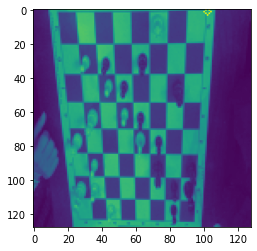

In [243]:
# Test data from dataset
image, y = tr_dataset.__getitem__(0)
image = image[0].numpy()
y = y.numpy()

i = 6
image = cv2.circle(image, center=(int(y[i]), int(y[i+1])), radius=2, color=1)

plt.imshow(image)
plt.show()

# Train

In [262]:
def start_train_loop(epochs, model, loaders, lr):
    print(f'Traning procces {epochs=} {lr=}')
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        train_metrics = train(model, loaders['train'], criterion, optim)
        valid_metrics = valid(model, loaders['valid'], criterion)
        
        print('='*50)
        print(f'train loss mean = {np.mean(train_metrics)}')
        print(f'valid loss mean = {np.mean(valid_metrics)}')
        print('='*50)

def train(model, trainloader, criterion, optim):
    model.train()
    loader = tqdm(trainloader, ncols=120)
    
    losses = []
    for im, l in loader:
        optim.zero_grad()
        pred = model(im)
        loss = criterion(pred, l)
        loss.backward()
        optim.step()

        loss=loss.item()
        losses.append(loss)
        loader.set_postfix_str(f'{loss=}')
    
    return losses

def valid(model, validloader, criterion):
    model.eval()
    loader = tqdm(validloader, ncols=120)
    
    losses = []
    for im, l in loader:
        pred = model(im)
        loss = criterion(pred, l)
        
        loss=loss.item()
        losses.append(loss)
        loader.set_postfix_str(f'{loss=}')
    return losses

In [265]:
start_train_loop(2, model, loaders, 1e-3)
start_train_loop(3, model, loaders, 1e-4)
start_train_loop(4, model, loaders, 1e-5)
start_train_loop(5, model, loaders, 1e-6)
start_train_loop(5, model, loaders, 1e-7)

Traning procces epochs=2 lr=0.001


100%|████████████████████████████████████████████████████████| 152/152 [00:18<00:00,  8.44it/s, loss=23.129438400268555]


train loss mean = 185.61675498666543
valid loss mean = 23.128789933104265


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.46it/s, loss=17.869600296020508]


train loss mean = 27.490189807249767
valid loss mean = 16.852019422932674
Traning procces epochs=3 lr=0.0001


100%|██████████████████████████████████████████████████████████| 152/152 [00:14<00:00, 10.19it/s, loss=2.28804612159729]


train loss mean = 11.473907907016994
valid loss mean = 4.910031900594109


100%|████████████████████████████████████████████████████████| 152/152 [00:15<00:00, 10.10it/s, loss=1.9094654321670532]


train loss mean = 8.907133296377982
valid loss mean = 4.512097742212446


100%|████████████████████████████████████████████████████████| 152/152 [00:15<00:00, 10.12it/s, loss=3.7291626930236816]


train loss mean = 7.51905877243961
valid loss mean = 3.5797549078339026
Traning procces epochs=4 lr=1e-05


100%|████████████████████████████████████████████████████████| 152/152 [00:14<00:00, 10.15it/s, loss=2.5640766620635986]


train loss mean = 5.6807595341905905
valid loss mean = 2.976521258291445


100%|█████████████████████████████████████████████████████████| 152/152 [00:14<00:00, 10.25it/s, loss=2.762756109237671]


train loss mean = 5.452320478930332
valid loss mean = 2.935495542852502


100%|████████████████████████████████████████████████████████| 152/152 [00:14<00:00, 10.32it/s, loss=1.9939125776290894]


train loss mean = 5.280750738512172
valid loss mean = 2.7028445052473167


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.55it/s, loss=2.8791260719299316]


train loss mean = 5.230640287839933
valid loss mean = 2.895867415164646
Traning procces epochs=5 lr=1e-06


100%|█████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.48it/s, loss=2.203356981277466]


train loss mean = 4.903874630188391
valid loss mean = 2.643282364857824


100%|████████████████████████████████████████████████████████| 152/152 [00:21<00:00,  7.17it/s, loss=2.0012707710266113]


train loss mean = 5.032907212134635
valid loss mean = 2.479277815473707


100%|██████████████████████████████████████████████████████████| 152/152 [00:18<00:00,  8.42it/s, loss=2.41404128074646]


train loss mean = 4.930096531661824
valid loss mean = 2.779771054261609


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.68it/s, loss=2.1717751026153564]


train loss mean = 4.8324230112651785
valid loss mean = 2.519394180492351


100%|█████████████████████████████████████████████████████████| 152/152 [00:15<00:00, 10.13it/s, loss=2.848966598510742]


train loss mean = 4.920669692184272
valid loss mean = 2.8493801292620207
Traning procces epochs=5 lr=1e-07


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.50it/s, loss=1.5943111181259155]


train loss mean = 4.872142951677342
valid loss mean = 2.2332195780779185


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.49it/s, loss=2.2706947326660156]


train loss mean = 4.858259297243439
valid loss mean = 2.638544762605115


100%|█████████████████████████████████████████████████████████| 152/152 [00:18<00:00,  8.36it/s, loss=2.154728412628174]


train loss mean = 4.897844071238741
valid loss mean = 2.4861707107016913


100%|████████████████████████████████████████████████████████| 152/152 [00:18<00:00,  8.44it/s, loss=2.1028623580932617]


train loss mean = 4.923648400275227
valid loss mean = 2.536290424434762


100%|████████████████████████████████████████████████████████| 152/152 [00:17<00:00,  8.59it/s, loss=2.6352012157440186]

train loss mean = 4.856193775391028
valid loss mean = 2.663344720476552


# Test

In [267]:
testpath = './xtest.npy'
data = np.load(testpath)[:,:,:,0]

test_dataset = DatasetChess(data, size=128)

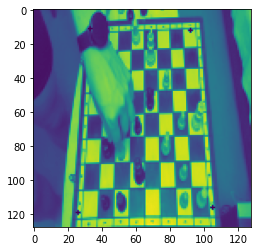

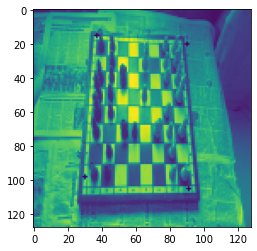

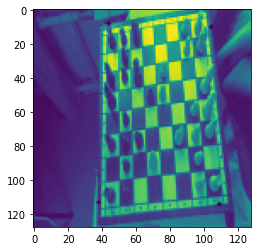

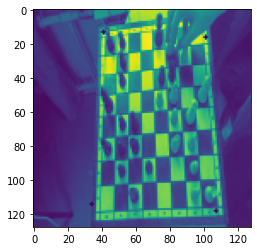

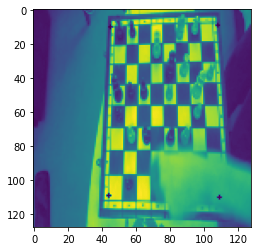

In [268]:
model.eval()
for i in range(5):
    image = test_dataset.__getitem__(i)[None][None]

    pred = model(image)

    image = image[0][0].numpy()
    for i in range(0, 8, 2):
        x, y = int(pred[0][i]),int(pred[0][i+1])
        image = cv2.circle(image, (x, y), radius=1, color=(0, 0, 255), thickness=-1)

    plt.imshow(image)
    plt.show()